In [1]:
from __future__ import print_function, division

# imports a library 'pandas', names it as 'pd'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime
import seaborn as sns

from IPython.display import Image

# enables inline plots, without it plots don't show up in the notebook
%matplotlib inline

In [2]:
# Source: http://web.mta.info/developers/turnstile.html
def get_data(week_nums):
    # base url
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        # concat our week onto url.. 
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [170610, 170617, 170624, 170701]
turnstiles_df = get_data(week_nums)

In [3]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [4]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " +turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [5]:
(turnstiles_df
 .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])
 .ENTRIES.count()
 .reset_index()
 .sort_values("ENTRIES", ascending=False)).head(5)

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES
713692,R518,R261,00-03-02,40 ST LOWERY ST,2017-06-05 08:00:00,2
526442,R147,R033,04-00-02,TIMES SQ-42 ST,2017-06-24 00:00:00,1
526443,R147,R033,04-00-02,TIMES SQ-42 ST,2017-06-24 04:00:00,1
526444,R147,R033,04-00-02,TIMES SQ-42 ST,2017-06-24 08:00:00,1
526445,R147,R033,04-00-02,TIMES SQ-42 ST,2017-06-24 12:00:00,1


In [6]:
turnstiles_df.sort_values(["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True, ascending=False)
# Get rid of the duplicate entry
turnstiles_df.drop_duplicates(subset=["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"], inplace=True)

In [7]:
turnstiles_hourly = turnstiles_df.groupby\
                (["C/A", "UNIT", "SCP", "STATION", "DATE_TIME"])\
                ['ENTRIES', 'EXITS'].first().reset_index()

In [8]:
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,2017-06-03 00:00:00,6203652,2101226
1,A002,R051,02-00-00,59 ST,2017-06-03 04:00:00,6203674,2101230
2,A002,R051,02-00-00,59 ST,2017-06-03 08:00:00,6203688,2101260
3,A002,R051,02-00-00,59 ST,2017-06-03 12:00:00,6203769,2101343
4,A002,R051,02-00-00,59 ST,2017-06-03 16:00:00,6203987,2101401


In [9]:
turnstiles_hourly[["PREV_DATE", "PREV_ENTRIES", "PREV_EXITS"]] = (turnstiles_hourly
                                                       .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE_TIME", "ENTRIES", "EXITS"]
                                                       .transform(lambda grp: grp.shift(1)))

In [10]:
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
0,A002,R051,02-00-00,59 ST,2017-06-03 00:00:00,6203652,2101226,NaT,NaN,NaN
1,A002,R051,02-00-00,59 ST,2017-06-03 04:00:00,6203674,2101230,2017-06-03 00:00:00,6203652.0,2101226.0
2,A002,R051,02-00-00,59 ST,2017-06-03 08:00:00,6203688,2101260,2017-06-03 04:00:00,6203674.0,2101230.0
3,A002,R051,02-00-00,59 ST,2017-06-03 12:00:00,6203769,2101343,2017-06-03 08:00:00,6203688.0,2101260.0
4,A002,R051,02-00-00,59 ST,2017-06-03 16:00:00,6203987,2101401,2017-06-03 12:00:00,6203769.0,2101343.0


In [11]:
turnstiles_hourly.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [12]:
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS
1,A002,R051,02-00-00,59 ST,2017-06-03 04:00:00,6203674,2101230,2017-06-03 00:00:00,6203652.0,2101226.0
2,A002,R051,02-00-00,59 ST,2017-06-03 08:00:00,6203688,2101260,2017-06-03 04:00:00,6203674.0,2101230.0
3,A002,R051,02-00-00,59 ST,2017-06-03 12:00:00,6203769,2101343,2017-06-03 08:00:00,6203688.0,2101260.0
4,A002,R051,02-00-00,59 ST,2017-06-03 16:00:00,6203987,2101401,2017-06-03 12:00:00,6203769.0,2101343.0
5,A002,R051,02-00-00,59 ST,2017-06-03 20:00:00,6204271,2101450,2017-06-03 16:00:00,6203987.0,2101401.0


In [13]:
def get_diffs(row, col_name, max_counter):
    prev_col = "PREV_" + col_name
    counter = row[col_name] - row[prev_col]

    if counter < 0:
        # May be counter is reversed?
        counter = -counter
    if counter > max_counter:
        counter = min(row[col_name], row[prev_col])
    if counter > max_counter:
        # Check it again to make sure we are not giving a counter that's too big
        return 0
    return counter

# If counter is > 1Million, then the counter might have been reset.  
# Just set it to zero as different counters have different cycle limits
turnstiles_hourly["HOURLY_ENTRIES"] = turnstiles_hourly.apply(get_diffs, axis=1, col_name='ENTRIES', max_counter=10000)
turnstiles_hourly["HOURLY_EXITS"] = turnstiles_hourly.apply(get_diffs, axis=1, col_name='EXITS', max_counter=10000)

In [14]:
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS
1,A002,R051,02-00-00,59 ST,2017-06-03 04:00:00,6203674,2101230,2017-06-03 00:00:00,6203652.0,2101226.0,22.0,4.0
2,A002,R051,02-00-00,59 ST,2017-06-03 08:00:00,6203688,2101260,2017-06-03 04:00:00,6203674.0,2101230.0,14.0,30.0
3,A002,R051,02-00-00,59 ST,2017-06-03 12:00:00,6203769,2101343,2017-06-03 08:00:00,6203688.0,2101260.0,81.0,83.0
4,A002,R051,02-00-00,59 ST,2017-06-03 16:00:00,6203987,2101401,2017-06-03 12:00:00,6203769.0,2101343.0,218.0,58.0
5,A002,R051,02-00-00,59 ST,2017-06-03 20:00:00,6204271,2101450,2017-06-03 16:00:00,6203987.0,2101401.0,284.0,49.0


In [15]:
turnstiles_hourly['TOTAL_TRAFFIC'] = turnstiles_hourly.HOURLY_ENTRIES + turnstiles_hourly.HOURLY_EXITS
turnstiles_hourly['DT_DIFF'] = turnstiles_hourly.DATE_TIME - turnstiles_hourly.PREV_DATE
turnstiles_hourly['MID_DT'] = turnstiles_hourly['PREV_DATE'] + turnstiles_hourly['DT_DIFF']/2
turnstiles_hourly['DOW'] = turnstiles_hourly['MID_DT'].dt.weekday_name
# Create WEEKEND field
weekend_indices = turnstiles_hourly[(turnstiles_hourly.DOW == 'Saturday') | (turnstiles_hourly.DOW == 'Sunday')].index
weekday_indices = turnstiles_hourly[(turnstiles_hourly.DOW != 'Saturday') & (turnstiles_hourly.DOW != 'Sunday')].index
turnstiles_hourly.loc[weekend_indices, 'WEEKEND'] = 'Weekend'
turnstiles_hourly.loc[weekday_indices, 'WEEKEND'] = 'Weekday'

In [16]:
turnstiles_hourly['SECONDS'] = turnstiles_hourly['DT_DIFF'].dt.total_seconds()

In [17]:
turnstiles_hourly.head()

,C/A,UNIT,SCP,STATION,DATE_TIME,ENTRIES,EXITS,PREV_DATE,PREV_ENTRIES,PREV_EXITS,HOURLY_ENTRIES,HOURLY_EXITS,TOTAL_TRAFFIC,DT_DIFF,MID_DT,DOW,WEEKEND,SECONDS
1,A002,R051,02-00-00,59 ST,2017-06-03 04:00:00,6203674,2101230,2017-06-03 00:00:00,6203652.0,2101226.0,22.0,4.0,26.0,04:00:00,2017-06-03 02:00:00,Saturday,Weekend,14400.0
2,A002,R051,02-00-00,59 ST,2017-06-03 08:00:00,6203688,2101260,2017-06-03 04:00:00,6203674.0,2101230.0,14.0,30.0,44.0,04:00:00,2017-06-03 06:00:00,Saturday,Weekend,14400.0
3,A002,R051,02-00-00,59 ST,2017-06-03 12:00:00,6203769,2101343,2017-06-03 08:00:00,6203688.0,2101260.0,81.0,83.0,164.0,04:00:00,2017-06-03 10:00:00,Saturday,Weekend,14400.0
4,A002,R051,02-00-00,59 ST,2017-06-03 16:00:00,6203987,2101401,2017-06-03 12:00:00,6203769.0,2101343.0,218.0,58.0,276.0,04:00:00,2017-06-03 14:00:00,Saturday,Weekend,14400.0
5,A002,R051,02-00-00,59 ST,2017-06-03 20:00:00,6204271,2101450,2017-06-03 16:00:00,6203987.0,2101401.0,284.0,49.0,333.0,04:00:00,2017-06-03 18:00:00,Saturday,Weekend,14400.0


# Plots

In [39]:
stationData = turnstiles_hourly.groupby(by=['STATION',], as_index=False).sum()[['STATION','TOTAL_TRAFFIC']].sort_values('TOTAL_TRAFFIC', ascending=False)

In [ ]:
top20 = stationData[:20]
top20Plot = sns.factorplot('STATION', 'TOTAL_TRAFFIC', data = top20, kind = 'bar', aspect = 2, size = 7, palette=sns.diverging_palette(220, 220, n=96))
top20Plot.set_xticklabels(rotation=90)


In [ ]:
turnstiles_hourly["DAY"] = turnstiles_hourly['DATE_TIME'].dt.weekday_name
dayOfWeekData = turnstiles_hourly.groupby(by="DAY", as_index=False).sum()[['DAY','TOTAL_TRAFFIC']].sort_values('TOTAL_TRAFFIC', ascending=False)
dayOfWeekPlot = sns.factorplot('DAY', 'TOTAL_TRAFFIC', data = dayOfWeekData, kind = 'bar', aspect = 2, size = 7, palette= color_state, order=["Monday","Tuesday","Wednesday","Thursday","Friday", "Saturday","Sunday"])


# GROUPER

In [124]:
#turnstiles_hourly('DATE_TIME').groupby('STATION')["TOTAL_TRAFFIC"].resample("hour").sum()

y = turnstiles_daily.groupby(['STATION', pd.Grouper(key='DATE_TIME', freq='D')])['TOTAL_TRAFFIC'].sum()

In [79]:
!pip3 install statsmodels

    100% |████████████████████████████████| 5.4MB 246kB/s ta 0:00:01


In [85]:
!pip3 install warnings

  Could not find a version that satisfies the requirement warnings (from versions: )
No matching distribution found for warnings


In [97]:
import warnings
import itertools
import statsmodels.api as sm

## Seasonal ARIMA 

In [114]:
PENN = y.ix["59 ST COLUMBUS"]
PENN.head()

DATE_TIME
2017-06-03 04:00:00     2871.0
2017-06-03 08:00:00     3325.0
2017-06-03 12:00:00    13397.0
2017-06-03 16:00:00    24162.0
2017-06-03 20:00:00    25655.0
Name: TOTAL_TRAFFIC, dtype: float64

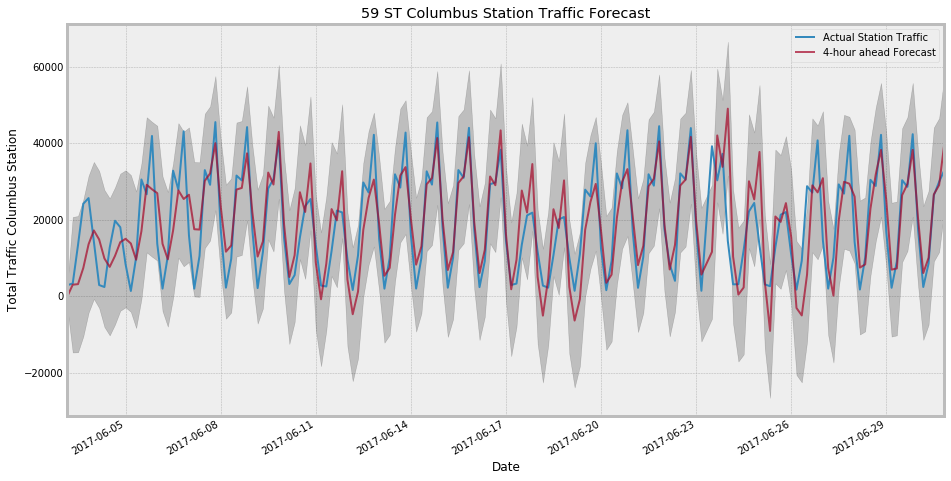

In [154]:
-

In [113]:
PENN.head()

DATE_TIME
2017-06-03 04:00:00     5585.0
2017-06-03 08:00:00    11828.0
2017-06-03 12:00:00    33866.0
2017-06-03 16:00:00    43983.0
2017-06-03 20:00:00    42743.0
Name: TOTAL_TRAFFIC, dtype: float64

In [126]:
y2 = turnstiles_hourly.groupby(['STATION', pd.Grouper(key='DATE_TIME', freq='4H')])['TOTAL_TRAFFIC'].sum().reset_index()

In [127]:
y2.head()

,STATION,DATE_TIME,TOTAL_TRAFFIC
0,1 AV,2017-06-03 04:00:00,2278.0
1,1 AV,2017-06-03 08:00:00,1344.0
2,1 AV,2017-06-03 12:00:00,5321.0
3,1 AV,2017-06-03 16:00:00,8763.0
4,1 AV,2017-06-03 20:00:00,9339.0


In [128]:
y2[y2["STATION"]=="59 ST COLUMBUS"]

,STATION,DATE_TIME,TOTAL_TRAFFIC
14193,59 ST COLUMBUS,2017-06-03 04:00:00,2871.0
14194,59 ST COLUMBUS,2017-06-03 08:00:00,3325.0
14195,59 ST COLUMBUS,2017-06-03 12:00:00,13397.0
14196,59 ST COLUMBUS,2017-06-03 16:00:00,24162.0
14197,59 ST COLUMBUS,2017-06-03 20:00:00,25655.0
14198,59 ST COLUMBUS,2017-06-04 00:00:00,14378.0
14199,59 ST COLUMBUS,2017-06-04 04:00:00,2918.0
14200,59 ST COLUMBUS,2017-06-04 08:00:00,2398.0
14201,59 ST COLUMBUS,2017-06-04 12:00:00,12719.0
14202,59 ST COLUMBUS,2017-06-04 16:00:00,19731.0


In [134]:
y2["HOUR"] = y2["DATE_TIME"].dt.hour

In [135]:
y2.head()

,STATION,DATE_TIME,TOTAL_TRAFFIC,HOUR
0,1 AV,2017-06-03 04:00:00,2278.0,4
1,1 AV,2017-06-03 08:00:00,1344.0,8
2,1 AV,2017-06-03 12:00:00,5321.0,12
3,1 AV,2017-06-03 16:00:00,8763.0,16
4,1 AV,2017-06-03 20:00:00,9339.0,20


In [146]:
HourCol = y2.groupby(by=['HOUR'], as_index=False).sum()